In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modelowanie rozwoju choroby na przykładzie koronawirusa

Tomasz Necio, projekt na zajęcia "Technologie chmury" @ MIM UW, sem. letni 2020

Take it with a grain of salt ;)

Na podstawie artykułu P. Krzyżanowskiego z Delty 12/2019 ["Zanim dopadnie nas grypa"](http://www.deltami.edu.pl/temat/matematyka/zastosowania/2019/11/25/2019-12-delta-grypa.pdf). Utworzono w IBM Watson Studio.

Tworzymy funkcję–model [Kermacka–McKendricka](https://mathworld.wolfram.com/Kermack-McKendrickModel.html) (`KMcK` z artykułu P. Krzyżanowskiego)

In [3]:
def model(a, b, s_0=100, i_0=1, r_0=0, n=1000):
    # a, b – współczynniki zdrowienia i zarażania się odpowiednio
    # s_0, i_0, r_0 – wartości początkowe s, i, r odpowiednio
    # n – długosć czasu symulacji
    s, i, r = np.zeros(n), np.zeros(n), np.zeros(n)
    s[0], i[0], r[0] = s_0, i_0, r_0
    for t in range(n - 1):
        s[t + 1] = s[t] - b * i[t] * s[t]
        i[t + 1] = i[t] + b * i[t] * s[t] - a * i[t]
        r[t + 1] = r[t] + a * i[t]
    return s, i, r

Weźmy epidemię koronawirusa w Polsce. 
Mamy wtedy zdrowych: 40 milionów (4 * 10 ** 7)
Chorych na dzień dajmy na to 10 marca: 22 (potwierdzonych, prawdopodbnie faktycznie było już wtedy dużo więcej)
Wyzdrowiałych: 0

$\frac{1}{a}$ to średnia długość czasu zarażania. Za [artykułem z TokFM](https://www.tokfm.pl/Tokfm/7,171710,25790727,bezobjawowe-przechodznie-koronawiursa-czy-da-sie-je-rozpoznac.html): "Osoby, które są nosicielami wirusa zarażają tak samo długo, jak chorzy z objawami, czyli dwa tygodnie." Dla koronawirusa załóżmy że będzie to około 12 dni (`a = 1 / 12`), biorąc małą poprawkę na samo-izolację, hospitalizacje itp., później może to poprawimy.
Wartość $b$ będziemy musieli wyznaczyć tak jak zrobił to pan P. Krzyżanowski w swoim artykule.


Do przewidzenia wartości b wykorzystajmy także dane z Włoch i z Korei Płd. Kraje te miały dwie różne strategie walki z koronawirusem. Być może uda się zobaczyć do którego jest nam bliżej.

In [20]:
# Legenda do "data": [deaths, recoveries, active cases]

# Dane z Włoch (za angielską Wikipedią):
italy_str = """{{Medical cases chart/Row|2020-02-22|2|2|79|||79|+295%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-23|3|2|150|||150|+90%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-24|6|1|227|||227|+51%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-25|10|1|320|||320|+41%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-26|12|3|445|||445|+39%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-27|17|45|650|||650|+46%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-28|21|46|888|||888|+37%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-02-29|29|50|1128|||1,128|+27%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-01|34|83|1694|||1,694|+50%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-02|52|149|2036|||2,036|+20%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-03|79|160|2502|||2,502|+23%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-04|107|276|3089|||3,089|+23%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-05|148|414|3858|||3,858|+25%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-06|197|523|4636|||4,636|+20%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-07|233|589|5883|||5,883|+27%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-08|366|622|7375|||7,375|+25%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-09|463|724|9172|||9,172|+24%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-10|631|1004|10149|||10,149|+11%{{efn-lr|name=delay_10Mar}}|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-11|827|1045|12462|||12,462|+23%{{efn-lr|name=delay_10Mar}}|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-12|1016|1258|15113|||15,113|+21%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-13|1266|1439|17660|||17,660|+17%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-14|1441|1966|21157|||21,157|+20%|factor=65|numwidth=mw}}
{{Medical cases chart/Row|2020-03-15|1809|2335|24747|||24,747|+17%|factor=65|numwidth=mw}}"""

italy_data = np.array([[int(l[2]), int(l[3]), int(l[4])] for l in [l.split("|") for l in italy_str.split("\n")]])
italy_pop = 60 * 10 ** 6
italy_schools_closed = 12
italy_day_0 = "2020-02-22"
italy = {"data" : italy_data, "pop" : italy_pop, "schools_closed" : italy_schools_closed, "name" : "Italy", "day_0" : italy_day_0}

In [21]:
# Dane z Korei (za angielską Wikipedią):
korea_str = """{{Medical cases chart/Row|2020-02-20|1|16|104|||104|+53||+104%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-21|2|17|204|||204|+100||+96%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-22|2|18|433|||433|+229||+112%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-23|4|18|602|||602|+169||+39%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-24|7|24|833|||833|+231||+38%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-25|10|24|977|||977|+144||+17%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-26|12|24|1261|||1,261|+284||+29%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-27|13|27|1766|||1,766|+505||+40%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-28|13|27|2337|||2,337|+571||+32%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-02-29|17|28|3150|||3,150|+813||+35%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-01|22|31|4212|||4,212|+1,062||+34%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-02|28|34|4812|||4,812|+600||+14%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-03|32|41|5328|||5,328|+516||+11%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-04|35|88|5766|||5,766|+438||+8.2%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-05|42|108|6284|||6,284|+518||+9.0%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-06|44|118|6767|||6,767|+483||+7.7%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-07|50|130|7134|||7,134|+367||+5.4%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-08|51|166|7382|||7,382|+248||+3.5%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-09|54|247|7513|||7,513|+131||+1.8%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-10|60|288|7755|||7,755|+242||+3.2%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-11|66|333|7869|||7,869|+114||+1.5%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-12|67|510|7979|||7,979|+110||+1.4%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-13|72|714|8086|||8,086|+107||+1.3%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-14|75|834|8162|||8,162|+76||+0.94%|factor=33|numwidth=twnw}}
{{Medical cases chart/Row|2020-03-15|75|1137|8236|||8,236|+74||+0.90%|factor=33|numwidth=twnw}}"""

korea_data = np.array([[int(l[2]), int(l[3]), int(l[4])] for l in [l.split("|") for l in korea_str.split("\n")]])
korea_pop = 51.7 * 10 ** 6
korea_schools_closed = 3
korea_day_0 = "2020-02-20"
korea = {"data" : korea_data, "pop" : korea_pop, "schools_closed" : korea_schools_closed, "name" : "South Korea", "day_0" : korea_day_0}

In [22]:
# Dane z Polski (za angielską Wikipedią):
poland_str = """{{Medical cases chart/Row|2020-03-04|0|0|1|||1|firstright1=y|factor=0.6}}
{{Medical cases chart/Row|2020-03-05|0|0|1|||1|+0%|factor=0.6}}
{{Medical cases chart/Row|2020-03-06|0|0|5|||5|+400%|factor=0.6}}
{{Medical cases chart/Row|2020-03-07|0|0|6|||6|+20%|factor=0.6}}
{{Medical cases chart/Row|2020-03-08|0|0|11|||11|+83%|factor=0.6}}
{{Medical cases chart/Row|2020-03-09|0|0|17|||17|+55%|factor=0.6}}
{{Medical cases chart/Row|2020-03-10|0|0|22|||22|+29%|factor=0.6}}
{{Medical cases chart/Row|2020-03-11|0|0|31|||31|+41%|factor=0.6}}
{{Medical cases chart/Row|2020-03-12|1|0|51|||51|+65%|factor=0.6}}
{{Medical cases chart/Row|2020-03-13|2|0|68|||68|+33%|factor=0.6}}
{{Medical cases chart/Row|2020-03-14|3|0|104|||104|+53%|factor=0.6}}
{{Medical cases chart/Row|2020-03-15|3|0|125|||125|+20%|factor=0.6}}
{{Medical cases chart/Row|2020-03-16|3|0|150|||150|+20%|factor=0.6}}"""

poland_data = np.array([[int(l[2]), int(l[3]), int(l[4])] for l in [l.split("|") for l in poland_str.split("\n")]])
poland_pop = 38 * 10 ** 6
poland_schools_closed = 7
poland_day_0 = "2020-03-04"
poland = {"data" : poland_data, "pop" : poland_pop, "schools_closed" : poland_schools_closed, "name" : "Poland", "day_0" : poland_day_0}

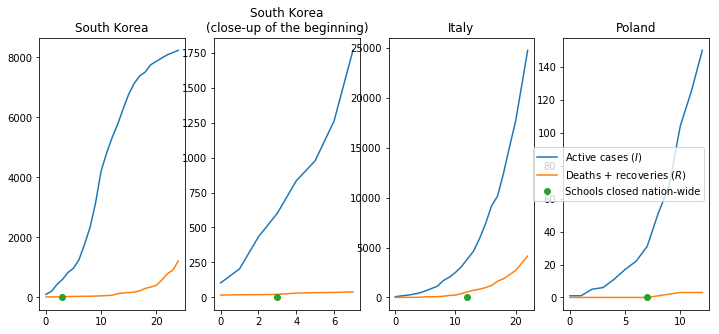

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1, 4, 1)
plt.plot(korea_data[:, 2], label="Active cases ($I$)")
plt.plot(korea_data[:,0] + korea_data[:, 1], label="Deaths + recoveries ($R$)")
plt.plot(korea_schools_closed, 0, 'o')
plt.title("South Korea")

plt.subplot(1, 4, 2)
plt.plot(korea_data[:8, 2], label="Active cases ($I$)")
plt.plot(korea_data[:8,0] + korea_data[:8, 1], label="Deaths + recoveries ($R$)")
plt.plot(korea_schools_closed, 0, 'o')
plt.title("South Korea\n(close-up of the beginning)")

plt.subplot(1, 4, 3)
plt.plot(italy_data[:, 2], label="Active cases ($I$)")
plt.plot(italy_data[:,0] + italy_data[:, 1], label="Deaths + recoveries ($R$)")
plt.plot(italy_schools_closed, 0, 'o')
plt.title("Italy")

plt.subplot(1, 4, 4)
plt.plot(poland_data[:, 2], label="Active cases ($I$)")
plt.plot(poland_data[:,0] + poland_data[:, 1], label="Deaths + recoveries ($R$)")
plt.plot(poland_schools_closed, 0, 'o', label="Schools closed nation-wide")
plt.title("Poland")
plt.legend()

Widać, że Korea dużo więcej ludzi testowała niż Polska czy Włochy, bo ma dużo większą dysproporcję między liczbą wyzdrowień/zgonów, a liczbą potwierdzonych przypadków. Dosyć wcześnie wprowadziła też zaostrzenia przepływu osób co tu symbolizujemy przez zaznaczenie dnia w którym zamknięte zostały wszystkie szkoły. Polska zareagowała równieższybko, natomiast Włochy dosyć późno. 

Sprawdźmy jakie $b$ wychodzi nam dla tych trzech krajów, metodą z artykułu Piotra Krzyżanowskiego. Stworzymy dwie funkcje podające odpowiednio liczbę osób które się uodporniły i osób które są zainfekowane wg modelu, z danymi początkowymi pochądzacymi z autentycznych danych o konkretnych państwach.

In [13]:
def f_r(b, country, n=30, spreading_days=12):
    # Returns recoveries and deaths modelled, default: over a month
    data = country["data"]
    a = 1 / spreading_days
    s_0 = country["pop"]
    s, i, r = model(a, b, s_0=s_0, i_0=data[0, 2], n=n)
    return r

def f_i(b, country, n=30, spreading_days=12):
    # Returns number of infected modelled, default: over a month
    data = country["data"]
    a = 1 / spreading_days
    s_0 = country["pop"]
    s, i, r = model(a, b, s_0=s_0, i_0=data[0, 2], n=n)
    return i

In [14]:
from scipy.optimize import leastsq
results = dict()
for country in [poland, korea, italy]:
    res = leastsq(lambda x : f_i(x, country, n=len(country["data"])) - country["data"][:, 2], 0.00000004)
    print(country["name"], res)
    results[country["name"]] = res[0]

Poland (array([1.63475355e-08]), 1)
South Korea (array([5.88560289e-09]), 1)
Italy (array([6.50057539e-09]), 1)


In [15]:
# A co gdy patrzymy na śmierci i wyzdrowienia zamiast na potwierdzone infekcje?
# Uwaga: dla Polski za mało jest tych danych by wyciągać jakieś wnioski

results = dict()
for country in [korea, italy]:
    res = leastsq(lambda x : f_r(x, country, n=len(country["data"])) - country["data"][:, 1] - country["data"][:, 0], 0.00000004)
    print(country["name"], res)
    results[country["name"]] = res[0]

South Korea (array([3.7867173e-09]), 1)
Italy (array([5.80909644e-09]), 1)


In [17]:
# A co jeżeli zarażamy krócej, np. średnio tylko 5 dni?

results = dict()
for country in [poland, korea, italy]:
    res = leastsq(lambda x : f_i(x, country, n=len(country["data"]), spreading_days=5) - country["data"][:, 2], 0.00000004)
    print(country["name"], res)
    results[country["name"]] = res[0]

Poland (array([1.94177159e-08]), 1)
South Korea (array([8.14252158e-09]), 1)
Italy (array([8.4453634e-09]), 1)


W każdym przypadku dostaliśmy wartości $b$: od około $3.8 \times 10^{-9}$ do około $1.6 \times 10^{-8}$. Przyjmijmy wartość dla Polski przy okresie zarażania wynoszącym 12 dni, dostaliśmy wtedy $1.6 \times 10^{-8}$. Warto tu zauważyć, że wartości dla Polski są trochę outlierami, bo i dla Włoch i dla Korei mimo ich różnego przebiegu choroby wartość $b$ wyniosła po około $5 \times 10^{-9}$. Jest wiele czynników które mają na to wpływ: Polska jest dopiero na wczesnym etapie epidemii, każdy kraj reagował inaczej itd.

Zobaczmy jak przy $b = 1.6 \times 10^{-8}$ może wyglądać przebieg choroby w naszym kraju (nie uwzględniamy tu zastosowania środków zapobiegawczych).

Text(0.5, 1.0, 'Poland (day 0: 2020-03-04) (long-term prediction)')

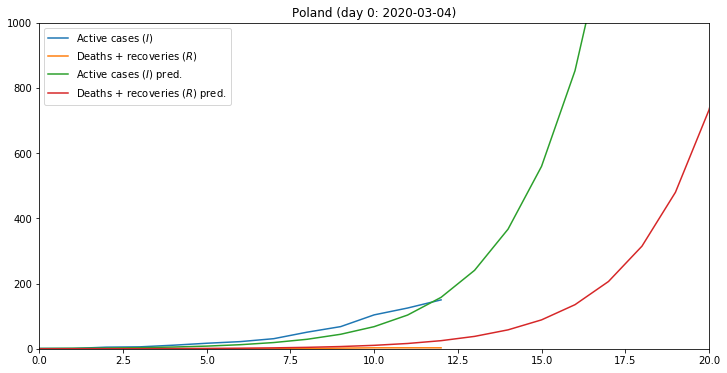

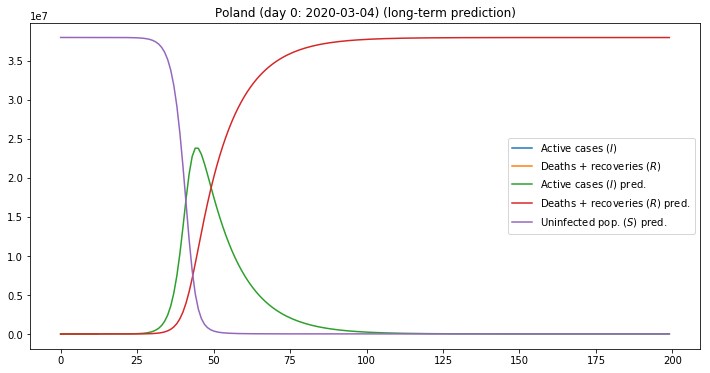

In [37]:
b = 1.6e-8

plt.figure(figsize=(12, 6))
plt.plot(poland_data[:, 2], label="Active cases ($I$)")
plt.plot(poland_data[:,0] + poland_data[:, 1], label="Deaths + recoveries ($R$)")
plt.plot(f_i(b, poland, n=200, spreading_days=12), label="Active cases ($I$) pred.")
plt.plot(f_r(b, poland, n=200, spreading_days=12), label="Deaths + recoveries ($R$) pred.")
plt.ylim(0, 1000)
plt.xlim(0, 20)
plt.legend()
plt.title("Poland (day 0: {})".format(poland["day_0"]))

plt.figure(figsize=(12, 6))
plt.plot(poland_data[:, 2], label="Active cases ($I$)")
plt.plot(poland_data[:,0] + poland_data[:, 1], label="Deaths + recoveries ($R$)")
plt.plot(f_i(b, poland, n=200, spreading_days=12), label="Active cases ($I$) pred.")
plt.plot(f_r(b, poland, n=200, spreading_days=12), label="Deaths + recoveries ($R$) pred.")
plt.plot(poland["pop"] - f_r(1.6e-8, poland, n=200, spreading_days=12) - f_i(1.6e-8, poland, n=200, spreading_days=12), label="Uninfected pop. ($S$) pred.")
plt.legend()
plt.title("Poland (day 0: {}) (long-term prediction)".format(poland["day_0"]))


A jeżeli uwzględnimy wprowadzenie w pewnym momencie obostrzeń i kwarantann które sprawiają, że ludzie kontaktują się ze soba mniej, częściej myją ręce i w efekcie roznoszenie się wirusa jest utrudnione (np. prawdopodobieństwo zarażenia zmniejszymy czterokrotnie)? Tutaj przyjmiemy za dzień spowolnienia w roznoszeniu wirasa dzień w którym w danych krajach zamknięto szkoły + opóźnienie związane z tym, że dane na których operujemy są opóźnione względem faktycznego stanu epidemii (chodzi o wyzdrowienia i infekcje, stwierdzenie śmierci oczywiście nie wymaga kilku dni). Tutaj za opóźnienie przyjmiemy okres inkubacji, czyli dla koronawirusa [około 5 dni](https://www.tokfm.pl/Tokfm/7,171710,25790727,bezobjawowe-przechodznie-koronawiursa-czy-da-sie-je-rozpoznac.html).

In [54]:
incubation_time = 5

# '_sd' stands for "with *s*ocial *d*istancing"

def f_i_sd(b, country, n=30, spreading_days=12, sd_coeff=4):
    # Returns number of infected modelled, default: over a month, includs correction for social distancing
    data = country["data"]
    a = 1 / spreading_days
    s_0 = country["pop"]
    s, i, r = np.zeros(n), np.zeros(n), np.zeros(n)
    sd = country["schools_closed"] + incubation_time # Time when social distancing starts to be enforced + delay of ca. incubation period
    s[:sd], i[:sd], r[:sd] = model(a, b, s_0=s_0, i_0=data[0, 2], n=sd)
    s_rest, i_rest, r_rest = model(a, b / sd_coeff, s_0=s[sd-1], i_0=i[sd-1], r_0=r[sd-1], n=n-sd+1)
    s[sd:], i[sd:], r[sd:] = s_rest[1:], i_rest[1:], r_rest[1:]
    return i

def f_r_sd(b, country, n=30, spreading_days=12, sd_coeff=4):
    # Returns number of infected modelled, default: over a month, includs correction for social distancing
    data = country["data"]
    a = 1 / spreading_days
    s_0 = country["pop"]
    s, i, r = np.zeros(n), np.zeros(n), np.zeros(n)
    sd = country["schools_closed"] + incubation_time # Time when social distancing starts to be enforced + delay of ca. incubation period
    s[:sd], i[:sd], r[:sd] = model(a, b, s_0=s_0, i_0=data[0, 2], n=sd)
    s_rest, i_rest, r_rest = model(a, b / sd_coeff, s_0=s[sd-1], i_0=i[sd-1], r_0=r[sd-1], n=n-sd+1)
    s[sd:], i[sd:], r[sd:] = s_rest[1:], i_rest[1:], r_rest[1:]
    return r

Musimy oczywiście jeszcze raz dopasować b

In [61]:
print("Without social distancing measures:")
results = dict()
for country in [poland, korea, italy]:
    res = leastsq(lambda x : f_i(x, country, n=len(country["data"])) - country["data"][:, 2], 0.00000004)
    print(country["name"], res[0])
    results[country["name"]] = res[0]

print()
print("With social distancing measures:")
for country in [poland, korea, italy]:
    res = leastsq(lambda x : f_i_sd(x, country, n=len(country["data"])) - country["data"][:, 2], b)
    print(country["name"], res[0])
    results[country["name"]] = res[0]

Without social distancing measures:
Poland [1.63475355e-08]
South Korea [5.88560289e-09]
Italy [6.50057539e-09]

With social distancing measures:
Poland [1.71199151e-08]
South Korea [1.29863409e-08]
Italy [7.79309256e-09]


Widzimy, że jeżeli uwzględnimy izolację ludzi, wychodzi nam większe $b$ – bo wirus jest rzeczywiście bardziej zaraźliwy niż przewidywał to naiwny model, ale izolacja pomaga zmniejszyć jego rozprzestrzenianie.
W Polsce mamy bardzo mało danych z czasu po wprowadzeniu zaostrzeń bo było to całkiem niedawno (około 5 dni temu, więc inne efektywne $b$ było właściwie tylko dla danych z ostatniego dnia). Dlatego ta wartość jest podobna do uzyskanej wcześniej.

In [90]:
def pred_sd(country, sd_coeff=4, n=500):
    b_sd = leastsq(lambda x : f_i_sd(x, country, n=len(country["data"]), sd_coeff=sd_coeff) - country["data"][:, 2], b)[0][0]
    
    plt.figure(figsize=(12, 6))
    short_n = len(country["data"][:, 0]) + 20
    plt.plot(country["data"][:, 2], label="Active cases ($I$)")
    plt.plot(country["data"][:,0] + country["data"][:, 1], label="Deaths + recoveries ($R$)")
    plt.plot(f_i_sd(b_sd, country, n=short_n, sd_coeff=sd_coeff), label="Active cases ($I$) pred.")
    plt.plot(f_r_sd(b_sd, country, n=short_n, sd_coeff=sd_coeff), label="Deaths + recoveries ($R$) pred.")
    #plt.ylim(0, 1000)
    plt.xlim(0, short_n)
    plt.legend()
    plt.title("{} (day 0: {}) ($b$ value: {:.3g})".format(country["name"], country["day_0"], b_sd))
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(country["data"][:, 2], label="Active cases ($I$)")
    plt.plot(country["data"][:,0] + country["data"][:, 1], label="Deaths + recoveries ($R$)")
    plt.plot(f_i_sd(b_sd, country, n=n, sd_coeff=sd_coeff), label="Active cases ($I$) pred.")
    plt.plot(f_r_sd(b_sd, country, n=n, sd_coeff=sd_coeff), label="Deaths + recoveries ($R$) pred.")
    plt.plot(- f_r_sd(b_sd, country, n=n, sd_coeff=sd_coeff) \
                   - f_i_sd(b_sd, country, n=n, sd_coeff=sd_coeff) \
                        + country["pop"], label="Uninfected pop. pred.")
    plt.legend()
    plt.title("{} (day 0: {}) (long-term prediction)".format(country["name"], country["day_0"]))
    plt.show()


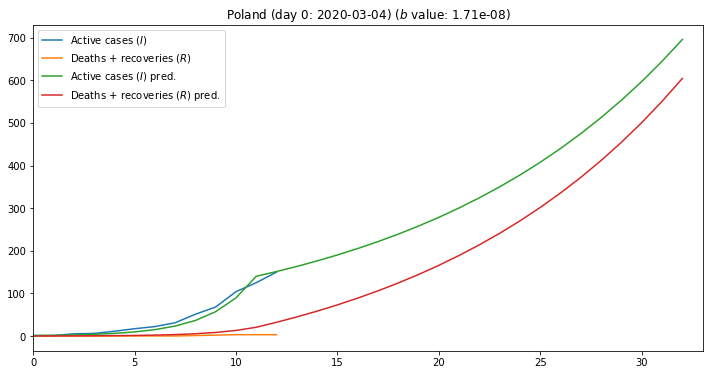

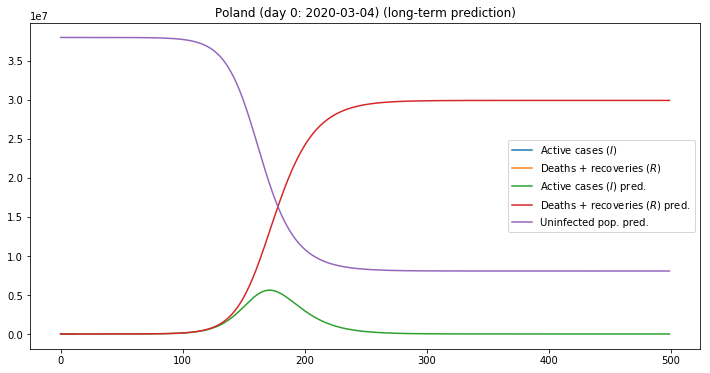

In [91]:
pred_sd(poland)
# Uwaga: dla większych `sd_coeff` ten model z jakiegoś powodu się psuje, być może to coś z numeryką bo liczby wtedy są rzędu 10 ** -10

# **Wnioski**: Zostań w domu!


---

A tu w ramach ciekawostki, to samo dla pozostałych krajów:

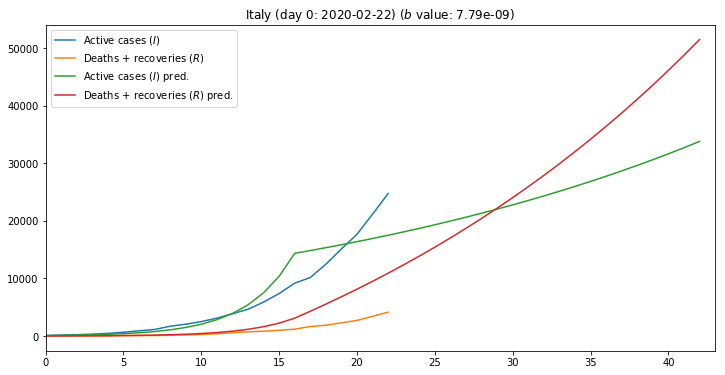

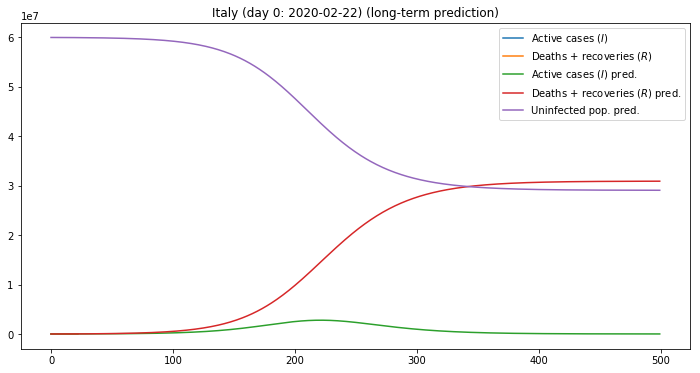

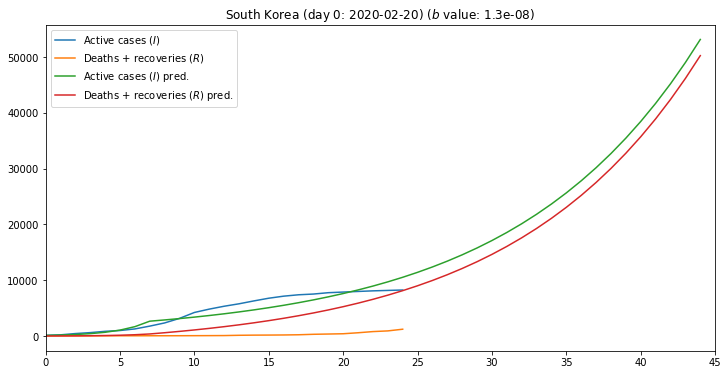

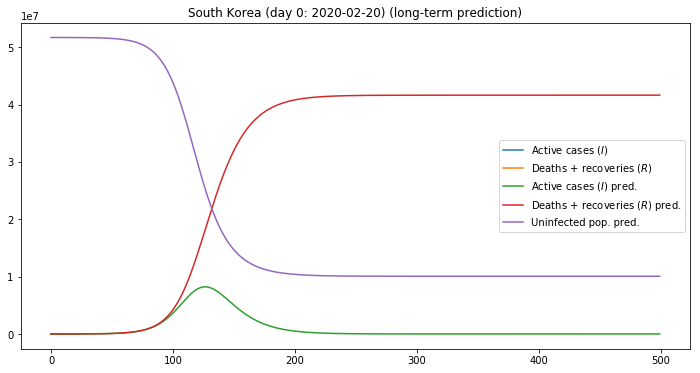

In [93]:
pred_sd(italy)
pred_sd(korea)

Moja hipoteza czemu model zupełnie nie sprawdza się dla Korei: tam od niemal samego początku użyto ekstensywnego testowania dużej części populacji i śledzenia osób z wynikiem pozytywnym oraz osób z którymi one miały kontakt w celu wprowadzenia dla nich kwarantanny jeszcze przed tym niż mają szanse kogokolwiek zarazić. Dlatego dla Korei efektywne $a$ mogło być o wiele mniejsze.